In [1]:
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]=""

import numpy as np
import itertools
from glob import glob

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import pickle

In [2]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

#### Import model, training function 

In [3]:
from annsa.model_classes import (DNN,
                                 CNN1D)

from annsa.load_pretrained_network import load_trained_model

from annsa import read_spectrum

from annsa.template_sampling import rebin_spectrum

from annsa.results_plotting_functions import *

# Load all models into dictionaries

In [4]:
all_models = {}
all_models_dataaug = {}

### Binarize labels, do this better

In [5]:
dataset = np.load('../dataset_generation/testing_dataset_full_200keV_100.npy')

mlb = LabelBinarizer()
keys = dataset.item()['keys']
mlb.fit(keys)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

### Load networks trained with data augmentation

In [6]:
all_models_dataaug = {}

for path in glob('../final_training_notebooks/final-models/learningcurve-*-dataaug-final_checkpoint*[0-9].i*'):

    model_id = path.split('learningcurve-')[1].split('_checkpoint')[0]
    model_index = path.split('checkpoint-')[1][0]
    model_id_complete = model_id+'-'+model_index
    print(model_id_complete)
    
    if 'c' in model_id:
        model_class = CNN1D
    else:
        model_class = DNN
    features_file_path = '../final_training_notebooks/final-models/learningcurve-'+model_id+'-features'
    weights_file_path = '../final_training_notebooks/final-models/learningcurve-'+model_id+'_checkpoint-'+model_index
    
    trained_model, _ = load_trained_model(model_class,
                                          features_file_path,
                                          weights_file_path,
                                          )

    all_models_dataaug[model_id_complete] = trained_model

cnn-easy-dataaug-final-4
dae-full-dataaug-final-4
dnn-easy-dataaug-final-3
cnn-full-dataaug-final-1
cae-easy-dataaug-final-2
dnn-full-dataaug-final-0
cae-easy-dataaug-final-1
cae-full-dataaug-final-2
cae-easy-dataaug-final-0
cae-easy-dataaug-final-3
dae-easy-dataaug-final-4
cae-full-dataaug-final-0
dnn-easy-dataaug-final-1
cnn-easy-dataaug-final-0
cnn-easy-dataaug-final-2
dae-easy-dataaug-final-0
dae-easy-dataaug-final-2
dae-full-dataaug-final-3
dnn-easy-dataaug-final-0
dae-full-dataaug-final-2
cae-full-dataaug-final-3
cae-full-dataaug-final-1
dnn-full-dataaug-final-1
cae-easy-dataaug-final-4
cnn-easy-dataaug-final-3
dnn-easy-dataaug-final-2
cae-full-dataaug-final-4
dae-easy-dataaug-final-1
dae-easy-dataaug-final-3
dae-full-dataaug-final-1
cnn-full-dataaug-final-0
dae-full-dataaug-final-0
cnn-easy-dataaug-final-1
dnn-easy-dataaug-final-4


### Load networks trained with fixed-size datasets

In [7]:
trainsize = 10000
file_path = '../final_training_notebooks/final-models/learningcurve-'

for path in glob(file_path+'*final*'+'_trainsize_'+str(trainsize)+'_*.index'):
    if 'stop' in path:
        continue
    model_id = path.split('learningcurve-')[1].split('_trainsize')[0]
    model_index = path.split('checkpoint_')[1][0]
    model_id_complete = model_id+'-'+model_index
    print(model_id_complete)
    
    if 'c' in model_id:
        model_class = CNN1D
    else:
        model_class = DNN
    features_file_path = '../final_training_notebooks/final-models/learningcurve-'+model_id+'-features'
    weights_file_path = '../final_training_notebooks/final-models/learningcurve-'+model_id+'_trainsize_'+str(trainsize)+'_checkpoint_'+model_index
    
    trained_model, _ = load_trained_model(model_class,
                                          features_file_path,
                                          weights_file_path,
                                          )
    all_models[model_id_complete] = trained_model
    
all_models.pop('cae-easy-final-5')
all_models.pop('cae-easy-final-6')

dae-easy-final-1
dnn-full-final-1
dae-easy-final-0
cae-easy-final-1
cae-easy-final-4
dae-easy-final-2
dnn-easy-final-4
dnn-easy-final-0
cnn-easy-final-0
cae-easy-final-0
cae-full-final-0
cae-full-final-2
cnn-easy-final-2
cae-full-final-3
dae-easy-final-4
cae-full-final-1
cae-easy-final-2
dae-full-final-4
cnn-full-final-2
cnn-easy-final-3
dae-full-final-0
cae-full-final-4
dnn-easy-final-2
cae-easy-final-3
cae-easy-final-5
cnn-full-final-0
dnn-full-final-4
dnn-easy-final-3
dnn-full-final-0
dnn-full-final-2
cnn-easy-final-1
dnn-easy-final-1
cae-easy-final-6
dae-full-final-2
cnn-easy-final-4
dnn-full-final-3
cnn-full-final-1
dae-full-final-1
dae-full-final-3
dae-easy-final-3


In [8]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def results2(res, number_isotopes_displayed):

    index = [i[0] for i in sorted(enumerate(res), key=lambda x:x[1])]
    index = list(reversed(index))
    for i in range(number_isotopes_displayed):
        print((mlb.classes_[index[i]], round(res[index[i]], 3)))
        
        
def models_bagged_probs(all_models, model_id, spectra):
    '''
    Bags a specific model's output from a dictionary of models.

    Inputs
        all_models : dict
            Dictionary containing all models
        model_id : string
            Specific model identifier such as 'dnn-full' or 'cae-easy'.
        spectra : numpy array
            Array containing multiple gamma-ray spectra

    Outputs
        output_mode : int
            The most frequent occuring output from the bagged model.
        output : list, int
            A list of outputs from each bagged model.
    '''
    output = []
    for model in all_models:

        if model_id in model:
            tmp_model = all_models[model]
            tmp_output = 100*softmax(tmp_model.forward_pass(spectra, training=False).numpy().flatten())
            output.append(tmp_output)

    output_mode = np.average(output, axis=0)

    return output_mode, output

In [9]:
def predictions_from_bagged_model(all_models,
                                  model_id,
                                  spectra,
                                  classes,
                                  num_isotopes=5,
                                  ):
    
    bagged_probs, _ = models_bagged_probs(all_models, model_id, spectra)
    output_probs_classes = [(x, y) for x, y in zip(bagged_probs, classes)]
    output_probs_classes_sorted = sorted(output_probs_classes, reverse=True)
    
    for i in range(num_isotopes):
        print('%.1f' % output_probs_classes_sorted[i][0],
              output_probs_classes_sorted[i][1])
    print('\n')
    

# Create results dataframe 

In [10]:
dataframe_data = []

In [11]:
isotope = 'eu152' # mlb.classes_[8]

pmt_gains = ['720v', '745v', '770v', '795v', '820v']
sb_ratios = [0.5, 1.0]



# for model_id in ['cnn-easy', 'dnn-easy', 'dae-easy', 'cae-easy']:

for sb_ratio in sb_ratios:
    for pmt_gain in pmt_gains:
        print(pmt_gain, sb_ratio, end='\r')
        spectra = []
        for path in glob('../training_testing_data/'+isotope+'_SB-'+str(sb_ratio)+'/detector129_'+pmt_gain+'_10s_*'):
            spectra.append(read_spectrum(path))
        spectra_cumsum = np.cumsum(spectra, axis=0)
#         for model_id in ['cnn-full-dataaug', 'dnn-full-dataaug', 'dae-full-dataaug', 'cae-full-dataaug', 'cnn-easy-dataaug', 'dnn-easy-dataaug', 'dae-easy-dataaug', 'cae-easy-dataaug']:        
        for model_id in ['cnn-full', 'dnn-full', 'dae-full', 'cae-full', 'cnn-easy', 'dnn-easy', 'dae-easy', 'cae-easy']:

            all_output_probs = []

            for i in range(30):
#             for i in [0,15,29]:
                bagged_output, all_outputs = models_bagged(all_models_dataaug, model_id, [spectra_cumsum[i]])
                bagged_probs, _ = models_bagged_probs(all_models_dataaug, model_id, [spectra_cumsum[i]])
                all_output_probs.append(bagged_probs)

            dataframe_data.append([model_id, sb_ratio, pmt_gain, isotope, all_output_probs])

In [12]:
isotope = 'co60' # mlb.classes_[8]

pmt_gains = ['720v', '745v', '770v', '795v', '820v']
sb_ratios = [0.5, 1.0]

for sb_ratio in sb_ratios:
    for pmt_gain in pmt_gains:
        print(pmt_gain, sb_ratio, end='\r')
        spectra = []
        for path in glob('../training_testing_data/'+isotope+'_SB-'+str(sb_ratio)+'/detector129_'+pmt_gain+'_10s_*'):
            spectra.append(read_spectrum(path))
        spectra_cumsum = np.cumsum(spectra, axis=0)

        for model_id in ['cnn-full', 'dnn-full', 'dae-full', 'cae-full', 'cnn-easy', 'dnn-easy', 'dae-easy', 'cae-easy']:
#         for model_id in ['cnn-full-dataaug', 'dnn-full-dataaug', 'dae-full-dataaug', 'cae-full-dataaug', 'cnn-easy-dataaug', 'dnn-easy-dataaug', 'dae-easy-dataaug', 'cae-easy-dataaug']:        
            all_output_probs = []

            for i in range(30):
                bagged_output, all_outputs = models_bagged(all_models_dataaug, model_id, [spectra_cumsum[i]])
                bagged_probs, _ = models_bagged_probs(all_models_dataaug, model_id, [spectra_cumsum[i]])
                all_output_probs.append(bagged_probs)

            dataframe_data.append([model_id, sb_ratio, pmt_gain, isotope, all_output_probs])

In [13]:
isotope = 'ba133' # mlb.classes_[8]

pmt_gains = ['720v', '745v', '770v', '820v']
sb_ratios = [0.5, 1.0]


for sb_ratio in sb_ratios:
    for pmt_gain in pmt_gains:
        print(pmt_gain, sb_ratio, end='\r')
        spectra = []
        for path in glob('../training_testing_data/'+isotope+'_SB-'+str(sb_ratio)+'/detector129_'+pmt_gain+'_10s_*'):
            spectra.append(read_spectrum(path))
        spectra_cumsum = np.cumsum(spectra, axis=0)

        for model_id in ['cnn-full', 'dnn-full', 'dae-full', 'cae-full', 'cnn-easy', 'dnn-easy', 'dae-easy', 'cae-easy']:
#         for model_id in ['cnn-full-dataaug', 'dnn-full-dataaug', 'dae-full-dataaug', 'cae-full-dataaug', 'cnn-easy-dataaug', 'dnn-easy-dataaug', 'dae-easy-dataaug', 'cae-easy-dataaug']:        
            all_output_probs = []

            for i in range(30):
                bagged_output, all_outputs = models_bagged(all_models_dataaug, model_id, [spectra_cumsum[i]])
                bagged_probs, _ = models_bagged_probs(all_models_dataaug, model_id, [spectra_cumsum[i]])
                all_output_probs.append(bagged_probs)

            dataframe_data.append([model_id, sb_ratio, pmt_gain, isotope, all_output_probs])

In [14]:
isotope = 'cs137' # mlb.classes_[8]

pmt_gains = ['720v', '745v', '770v', '795v', '820v']
sb_ratios = [0.5, 1.0]



# for model_id in ['cnn-easy', 'dnn-easy', 'dae-easy', 'cae-easy']:

for sb_ratio in sb_ratios:
    for pmt_gain in pmt_gains:
        print(pmt_gain, sb_ratio, end='\r')
        spectra = []
        for path in glob('../training_testing_data/'+isotope+'_SB-'+str(sb_ratio)+'/detector129_'+pmt_gain+'_10s_*'):
            spectra.append(read_spectrum(path))
        spectra_cumsum = np.cumsum(spectra, axis=0)
        

        for model_id in ['cnn-full', 'dnn-full', 'dae-full', 'cae-full', 'cnn-easy', 'dnn-easy', 'dae-easy', 'cae-easy']:
#         for model_id in ['cnn-full-dataaug', 'dnn-full-dataaug', 'dae-full-dataaug', 'cae-full-dataaug', 'cnn-easy-dataaug', 'dnn-easy-dataaug', 'dae-easy-dataaug', 'cae-easy-dataaug']:        
            all_output_probs = []

            for i in range(30):
                bagged_output, all_outputs = models_bagged(all_models_dataaug, model_id, [spectra_cumsum[i]])
                bagged_probs, _ = models_bagged_probs(all_models_dataaug, model_id, [spectra_cumsum[i]])
                all_output_probs.append(bagged_probs)

            dataframe_data.append([model_id, sb_ratio, pmt_gain, isotope, all_output_probs])

### Make data to fill in missing spectra of ba133 at 795v at sb_ratio of 0.5

In [15]:
from scipy.interpolate import griddata

def rebin_spectrum(spectrum_template, a=0, b=1, c=0):
    '''
    Rebins spectrum based on quadratic rebinning. Returns a 1024 channel
    spectrum.

    inputs:
        spectrum_template : vector (1x1194)
            The spectrums template
        a : float
            Constant rebinning term
        b : float
            Linear rebinning term
        c : float
            Quadratic rebinning term
    returns:
        rebinned_spectrum_template : vector (1x1194)
            The rebinned spectrum template
    '''

    new_bin_positions = a + b*np.arange(1024) + c*np.arange(1024)**2

    spectrum_template = griddata(np.arange(1024),
                                 spectrum_template,
                                 new_bin_positions,
                                 method='cubic',
                                 fill_value=0.0)
    spectrum_template[spectrum_template < 0] = 0
    return spectrum_template[:1024]

In [16]:
isotope = 'ba133' # mlb.classes_[8]

pmt_gains = ['795v']
sb_ratios = [0.5]


for sb_ratio in sb_ratios:
    for pmt_gain in pmt_gains:
        print(pmt_gain, sb_ratio, end='\r')
        spectra = []
        for path in glob('../training_testing_data/'+isotope+'_SB-'+str(sb_ratio)+'/detector129_'+'770v'+'_10s_*'):
            spectra.append(rebin_spectrum(read_spectrum(path), a=0, b=1/1.27, c=0))           
        spectra_cumsum = np.cumsum(spectra, axis=0)

        for model_id in ['cnn-full', 'dnn-full', 'dae-full', 'cae-full', 'cnn-easy', 'dnn-easy', 'dae-easy', 'cae-easy']:
#         for model_id in ['cnn-full-dataaug', 'dnn-full-dataaug', 'dae-full-dataaug', 'cae-full-dataaug', 'cnn-easy-dataaug', 'dnn-easy-dataaug', 'dae-easy-dataaug', 'cae-easy-dataaug']:        
            all_output_probs = []

            for i in range(30):
                bagged_output, all_outputs = models_bagged(all_models_dataaug, model_id, [spectra_cumsum[i]])
                bagged_probs, _ = models_bagged_probs(all_models_dataaug, model_id, [spectra_cumsum[i]])
                all_output_probs.append(bagged_probs)

            dataframe_data.append([model_id, sb_ratio, pmt_gain, isotope, all_output_probs])

In [17]:
isotope = 'ba133' # mlb.classes_[8]

pmt_gains = ['795v']
sb_ratios = [1.0]


for sb_ratio in sb_ratios:
    for pmt_gain in pmt_gains:
        print(pmt_gain, sb_ratio, end='\r')
        spectra = []
        for path in glob('../training_testing_data/'+isotope+'_SB-'+str(sb_ratio)+'/detector129_'+pmt_gain+'_10s_*'):
            spectra.append(read_spectrum(path))
        spectra_cumsum = np.cumsum(spectra, axis=0)


        for model_id in ['cnn-full', 'dnn-full', 'dae-full', 'cae-full', 'cnn-easy', 'dnn-easy', 'dae-easy', 'cae-easy']:
#         for model_id in ['cnn-full-dataaug', 'dnn-full-dataaug', 'dae-full-dataaug', 'cae-full-dataaug', 'cnn-easy-dataaug', 'dnn-easy-dataaug', 'dae-easy-dataaug', 'cae-easy-dataaug']:        
            all_output_probs = []

            for i in range(30):
                bagged_output, all_outputs = models_bagged(all_models_dataaug, model_id, [spectra_cumsum[i]])
                bagged_probs, _ = models_bagged_probs(all_models_dataaug, model_id, [spectra_cumsum[i]])
                all_output_probs.append(bagged_probs)

            dataframe_data.append([model_id, sb_ratio, pmt_gain, isotope, all_output_probs])

### Save data in dataframe

In [18]:
columns = ['model_id', 'sb_ratio', 'pmt_gain', 'isotope', 'posterior_prob']

results_dataframe = pd.DataFrame(dataframe_data, columns=columns)

# results_dataframe.to_pickle('measured_sources_gain_performance_dataaug')

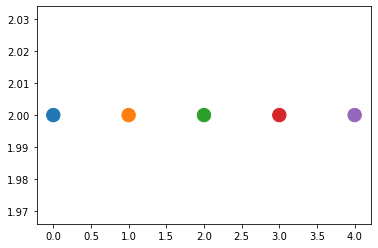

In [19]:
import matplotlib.colors

def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = matplotlib.colors.ListedColormap(cols)
    return cmap

c1 = categorical_cmap(5,1, cmap="tab10")
plt.scatter(np.arange(5*1),np.ones(5*1)+1, c=np.arange(5*1), s=180, cmap=c1)


In [20]:
linestyles = ['-', '--', '-.', ':']

## Relative gain shift calculation

In [21]:
spectra = {}
pmt_gains = ['720v', '745v', '770v', '795v', '820v']


for pmt_gain in pmt_gains:
    spectra[pmt_gain] = np.zeros(1024)
    for path in glob('../training_testing_data/cs137_SB-1.0/detector129_'+pmt_gain+'_10s_*'):
        spectra[pmt_gain] += read_spectrum(path)


141
185
237
301
379


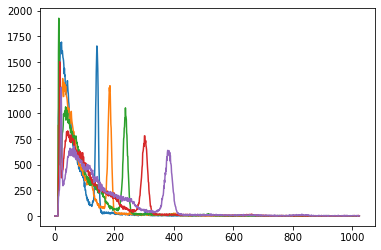

In [22]:
centroids = {}

for pmt_gain in pmt_gains:
    plt.plot(spectra[pmt_gain])
    print(100+np.argmax(spectra[pmt_gain][100:]))
    centroids[pmt_gain] = 100+np.argmax(spectra[pmt_gain][100:])

(0.01, 10000.0)

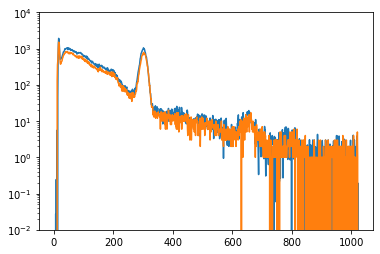

In [23]:
plt.plot(rebin_spectrum(spectra['770v'], a=0, b=1/1.27, c=0))
plt.plot(spectra['795v'])
plt.semilogy()
plt.ylim([1e-2,1e4])

In [24]:
for pmt_gain in pmt_gains:
    print(centroids[pmt_gain]/centroids['745v'])

0.7621621621621621
1.0
1.281081081081081
1.627027027027027
2.0486486486486486


In [25]:
def plot_measured_source_results(results_dataframe,
                                 isotope,
                                 gadras_isotope,
                                 sb_ratio,
                                 setting,
                                 pmt_gains):
    
    gadras_index = np.argwhere(mlb.classes_ == gadras_isotope).flatten()[0]
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(10,5))
    for option_index, pmt_gain in enumerate(pmt_gains):
        for model_idindex, model_id in enumerate(['cae-'+setting,
                                                  'dae-'+setting,
                                                  'dnn-'+setting,
                                                  'cnn-'+setting,]):
            results_dataframe_tmp = results_dataframe[results_dataframe['model_id'] == model_id]
            results_dataframe_tmp = results_dataframe_tmp[results_dataframe_tmp['sb_ratio'] == sb_ratio]
            results_dataframe_tmp = results_dataframe_tmp[results_dataframe_tmp['isotope'] == isotope]
            results_dataframe_tmp = results_dataframe_tmp[results_dataframe_tmp['pmt_gain'] == pmt_gain]

            plt.plot(np.linspace(10,300,30),
                     np.array(results_dataframe_tmp['posterior_prob'].values[0]).reshape(30,30)[:,gadras_index], 
                     label=pmt_gain,
                     linewidth=2.5,
                     linestyle=linestyles[option_index],
                     color=c1.colors[model_idindex],)

    plt.xlabel('Integration Time (seconds)')
    plt.ylabel('Posterior Probability')       
    plt.ylim([0,110])

In [26]:
save_fig = False
plot_title = True

## Eu152

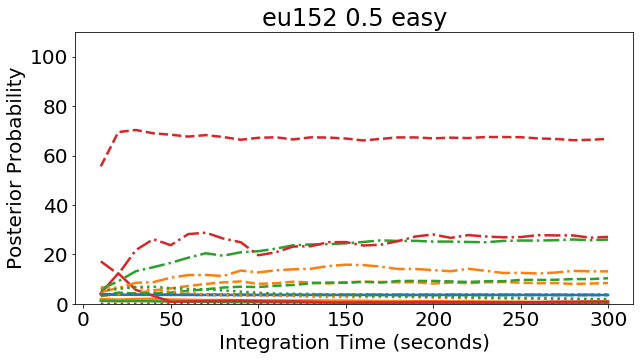

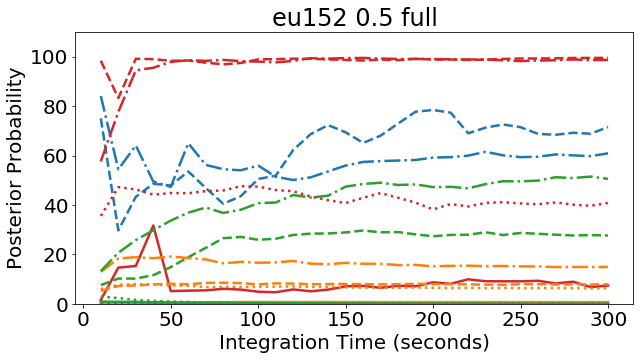

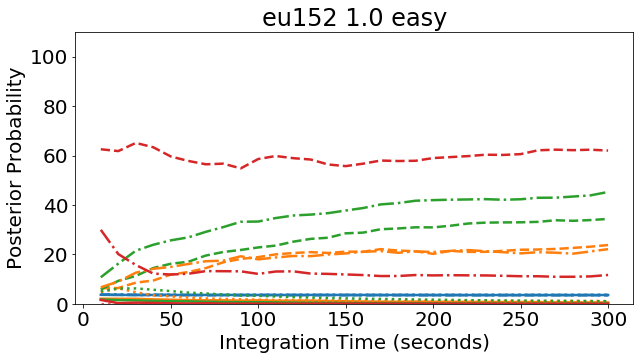

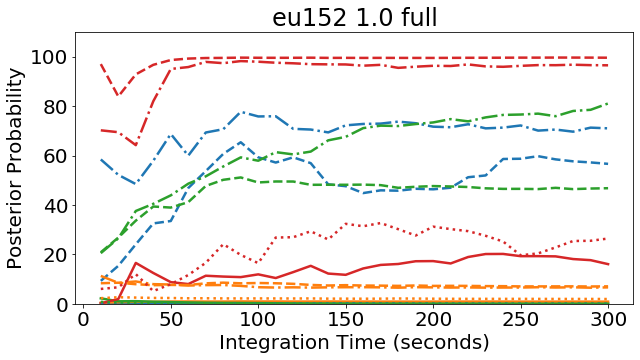

In [27]:
isotope = 'eu152'
gadras_isotope = '152EU'

for sb_ratio in [0.5, 1.0]:
    for setting in ['easy', 'full']:
        plot_measured_source_results(results_dataframe=results_dataframe,
                                     isotope=isotope,
                                     gadras_isotope=gadras_isotope,
                                     sb_ratio=sb_ratio,
                                     setting=setting,
                                     pmt_gains=['720v', '745v', '770v', '795v'],)
        if plot_title:
            plt.title(isotope+' '+str(sb_ratio)+' '+setting,)
        if save_fig:
            plt.savefig('realspectra-cal-'+isotope+'-'+str(sb_ratio)[0]+'-'+setting)

## Ba133

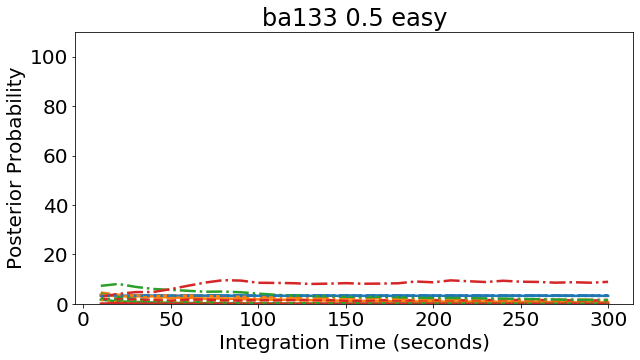

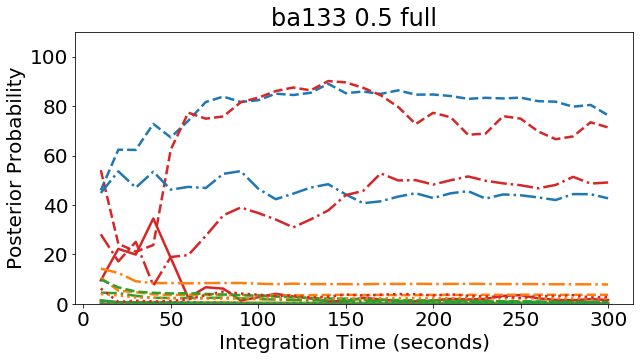

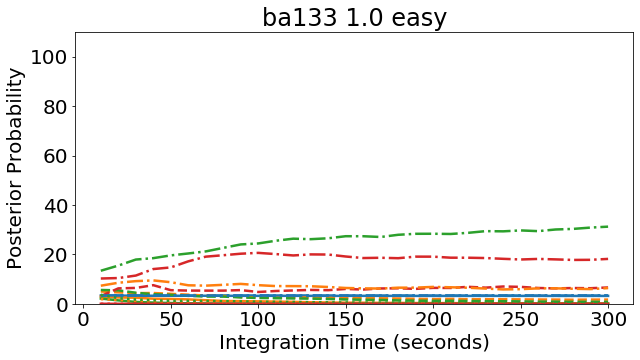

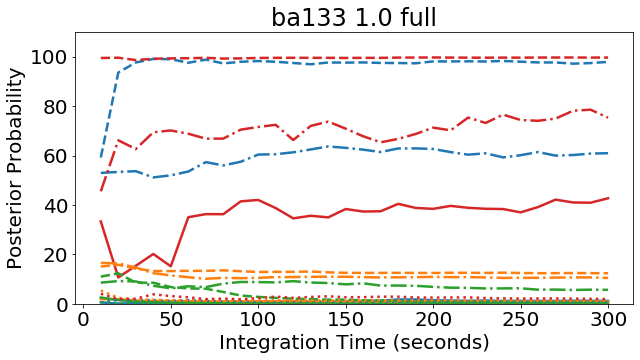

In [28]:
isotope = 'ba133'
gadras_isotope = '133BA'

for sb_ratio in [0.5, 1.0]:
    for setting in ['easy', 'full']:
        plot_measured_source_results(results_dataframe=results_dataframe,
                                     isotope=isotope,
                                     gadras_isotope=gadras_isotope,
                                     sb_ratio=sb_ratio,
                                     setting=setting,
                                     pmt_gains=['720v', '745v', '770v', '795v'],)
        if plot_title:
            plt.title(isotope+' '+str(sb_ratio)+' '+setting,)
        if save_fig:
            plt.savefig('realspectra-cal-'+isotope+'-'+str(sb_ratio)[0]+'-'+setting)

## Co60

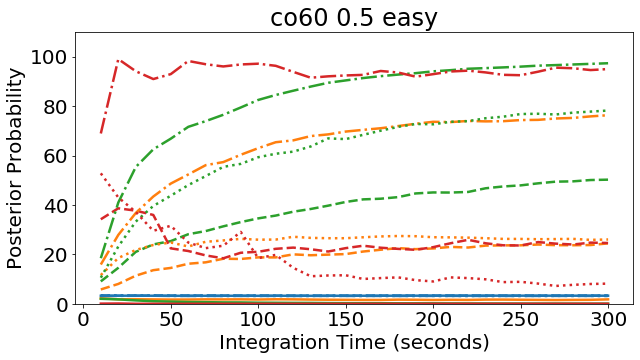

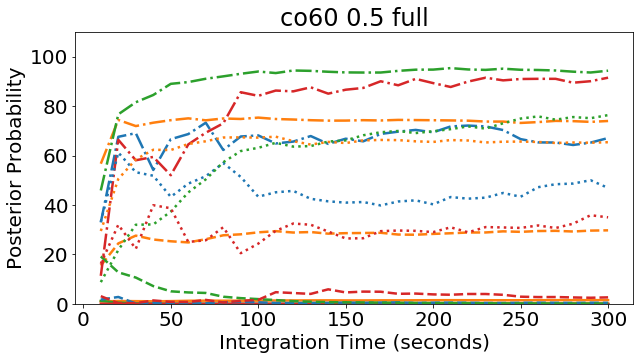

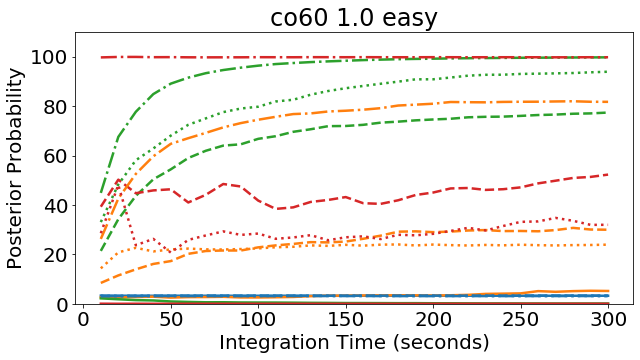

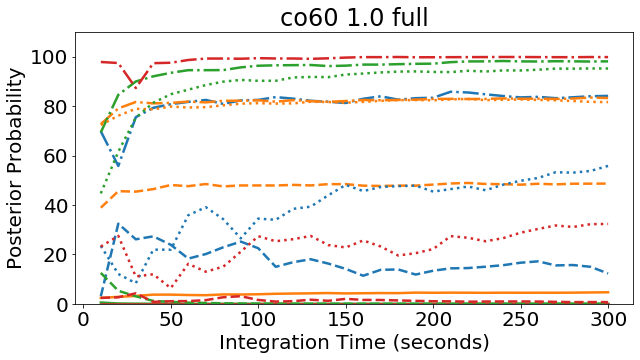

In [29]:
isotope = 'co60'
gadras_isotope = '60CO'

for sb_ratio in [0.5, 1.0]:
    for setting in ['easy', 'full']:
        plot_measured_source_results(results_dataframe=results_dataframe,
                                     isotope=isotope,
                                     gadras_isotope=gadras_isotope,
                                     sb_ratio=sb_ratio,
                                     setting=setting,
                                     pmt_gains=['720v', '745v', '770v', '795v'],)
        if plot_title:
            plt.title(isotope+' '+str(sb_ratio)+' '+setting,)
        if save_fig:
            plt.savefig('realspectra-cal-'+isotope+'-'+str(sb_ratio)[0]+'-'+setting)

## Cs137

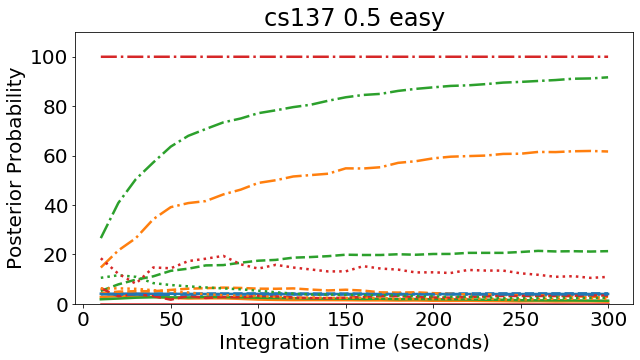

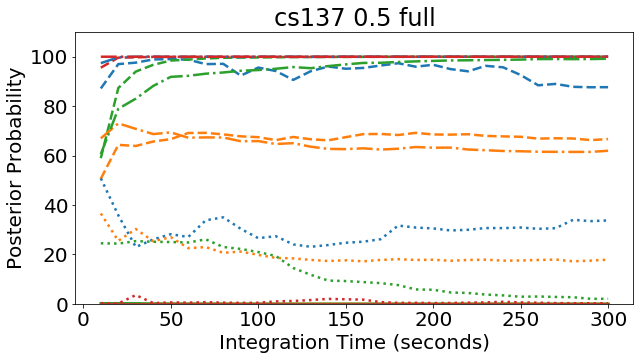

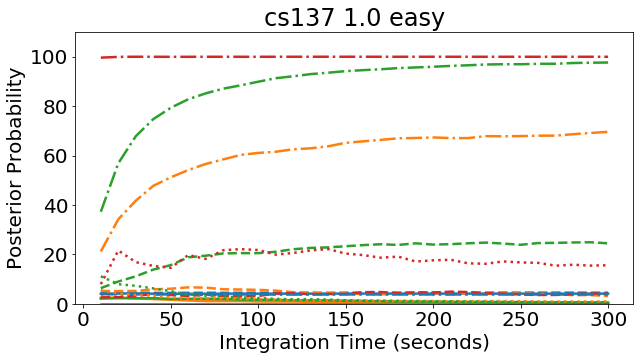

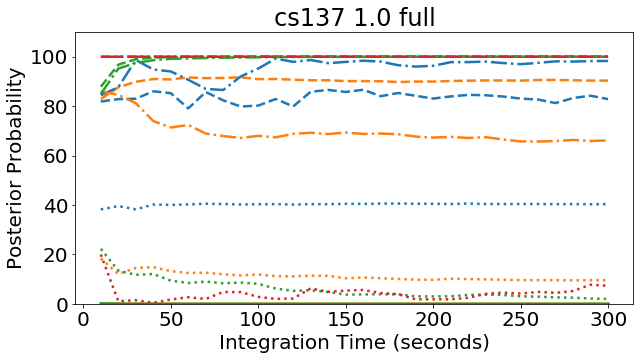

In [30]:
isotope = 'cs137'
gadras_isotope = '137CS'

for sb_ratio in [0.5, 1.0]:
    for setting in ['easy', 'full']:
        plot_measured_source_results(results_dataframe=results_dataframe,
                                     isotope=isotope,
                                     gadras_isotope=gadras_isotope,
                                     sb_ratio=sb_ratio,
                                     setting=setting,
                                     pmt_gains=['720v', '745v', '770v', '795v'],)
        if plot_title:
            plt.title(isotope+' '+str(sb_ratio)+' '+setting,)
        if save_fig:
            plt.savefig('realspectra-cal-'+isotope+'-'+str(sb_ratio)[0]+'-'+setting)

# Put it in a dataframe

In [31]:
columns = ['model_id', 'sb_ratio', 'gain', 'isotope', 'posterior_prob']

results_dataframe = pd.DataFrame(columns=columns)

In [177]:
spectra = []

isotope = 'eu152' # mlb.classes_[8]
# isotope = 'ba133' # mlb.classes_[5]
# isotope = 'co60' # mlb.classes_[24]
# isotope = 'cs137' # mlb.classes_[7]

# pmt_gain = '720v'
pmt_gain = '745v'
# pmt_gain = '770v'
# pmt_gain = '795v'
# pmt_gain = '820v'

sb_ratio = '0.5'
# sb_ratio = '1.0'



for path in glob('../training_testing_data/'+isotope+'_SB-'+sb_ratio+'/detector129_'+pmt_gain+'_10s_*'):
    spectra.append(read_spectrum(path))
spectra_cumsum = np.cumsum(spectra, axis=0)


all_output_probs_easy = {}

# for model_id in ['cnn-easy', 'dnn-easy', 'dae-easy', 'cae-easy']:
for model_id in ['cnn-full', 'dnn-full', 'dae-full', 'cae-full']:

    all_output_probs[model_id] = []

    for i in range(30):
        bagged_output, all_outputs = models_bagged(all_models, model_id, [spectra_cumsum[i]])
#         print(model_id+' predicts: '+str(mlb.classes_[bagged_output[0]]))
        bagged_probs, _ = models_bagged_probs(all_models, model_id, [spectra_cumsum[i]])
        all_output_probs[model_id].append(bagged_probs[8])
        
    print('\n')


cnn-full
dnn-full
dae-full
cae-full


Text(0, 0.5, 'Posterior Probability')

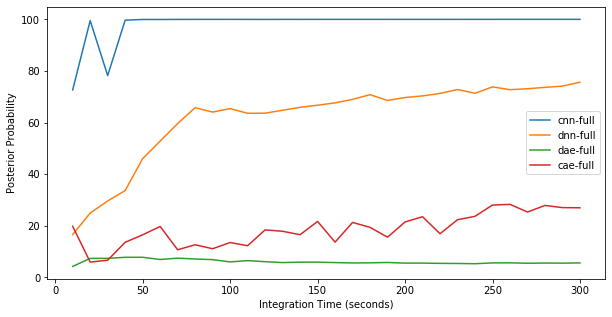

In [222]:
plt.figure(figsize=(10,5))

for model_idindex, model_id in enumerate(all_output_probs):
    print(model_id)
    plt.plot(np.linspace(10,300,30), all_output_probs[model_id], label = model_id)

plt.legend()



plt.xlabel('Integration Time (seconds)')
plt.ylabel('Posterior Probability')


In [207]:
np.linspace(10,30*10,6)

array([ 10.,  68., 126., 184., 242., 300.])

In [134]:
all_outputs

[array([8]), array([8]), array([8]), array([5]), array([10])]

In [11]:
def models_bagged(all_models, model_id, spectra):
    '''
    Bags a specific model's output from a dictionary of models.

    Inputs
        all_models : dict
            Dictionary containing all models
        model_id : string
            Specific model identifier such as 'dnn-full' or 'cae-easy'.
        spectra : numpy array
            Array containing multiple gamma-ray spectra

    Outputs
        output_mode : int
            The most frequent occuring output from the bagged model.
        output : list, int
            A list of outputs from each bagged model.
    '''
    output = []
    for model in all_models:

        if model_id in model:
            tmp_model = all_models[model]
            tmp_output = tmp_model.predict_class(spectra).numpy().flatten()
            output.append(tmp_output)

    output_mode = mode(output, axis=0)[0].flatten()

    return output_mode, output

cnn-easy:
35.2 60CO
22.4 137CS
19.9 67GA
9.9 51CR
2.7 192IR


dnn-easy:
6.9 111IN
6.3 67GA
5.5 background
5.2 51CR
4.8 192IR


dae-easy:
5.0 51CR
5.0 111IN
4.5 192IR
4.5 67GA
4.3 123I


cae-easy:
4.6 99MO
4.5 75SE
4.3 152EU
4.1 238U
4.0 235U




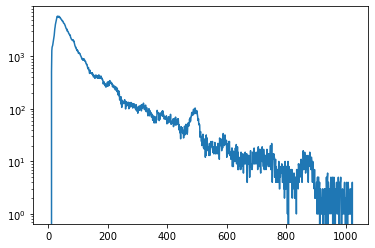

In [131]:
# background_1800 = read_spectrum('../../source-interdiction/training_testing_data/06-18-19/background_1800.Spe')
# background_1800 = read_spectrum('../../source-interdiction/training_testing_data/06-20-19/back_1800.Spe')
background_1800 = read_spectrum('../../source-interdiction/training_testing_data/06-21-19/background_1800.Spe')


for model_id in ['cnn-easy', 'dnn-easy', 'dae-easy', 'cae-easy']:
# for model_id in ['cnn-full', 'dnn-full', 'dae-full', 'cae-full']:
    print(model_id + ':')
#   predictions_from_bagged_model(all_models,
    predictions_from_bagged_model(all_models_dataaug,
                                  model_id,
                                  [np.random.poisson(background_1800/1500.)],
                                  mlb.classes_,)
    
    
plt.semilogy(background_1800)

In [108]:
spectra = []

# for path in glob('../../uranium-enrichment/rocky_flats_spectra/RFshells-740V/10s_TEST_number_*'):
for path in glob('../../uranium-enrichment/rocky_flats_spectra/RFshellsandIron-750V/10s_TEST_number_*'):
# for path in glob('../../uranium-enrichment/rocky_flats_spectra/RFshellsandTungsten-740V/10s_TEST_number_*'):
    spectra.append(read_spectrum(path))
spectra_cumsum = np.cumsum(spectra, axis=0)
spectra_cumsum_iron = spectra_cumsum
# spectra_cumsum = [rebin_spectrum(spectrum, a=0, b=1.99, c=0) for spectrum in spectra_cumsum]

for model_id in ['cnn-full', 'dnn-full', 'dae-full', 'cae-full']:
# for model_id in ['cnn-easy', 'dnn-easy', 'dae-easy', 'cae-easy']:
    print(model_id + ':')
    for i in [0]:
#    for i in [3]:
        # bagged_output, all_outputs = models_bagged(all_models_dataaug, model_id, [spectra_cumsum[i]])
#         predictions_from_bagged_model(all_models,
        predictions_from_bagged_model(all_models_dataaug,
                                      model_id,
                                      [spectra_cumsum[i]],
                                      mlb.classes_,)
#         print('\n')
        # print(model_id+' predicts: '+str(mlb.classes_[bagged_output[0]]))
#     print('\n')



cnn-full:
100.0 235U
0.0 177MLU
0.0 233U
0.0 123I
0.0 67GA


dnn-full:
24.2 235U
18.9 111IN
11.3 67GA
8.6 177MLU
6.8 99MO


dae-full:
61.8 111IN
13.5 177MLU
7.0 67GA
4.0 235U
2.3 51CR


cae-full:
88.9 235U
5.6 123I
2.9 111IN
1.3 51CR
0.6 75SE




Text(0, 0.5, 'Counts per Channel')

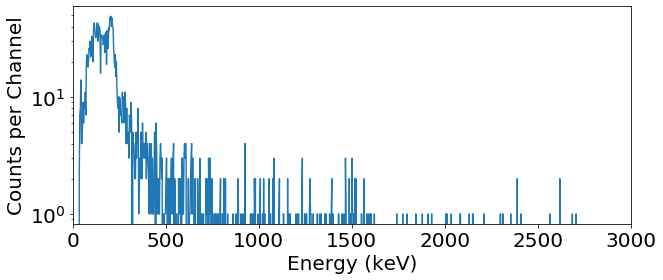

In [113]:
0
plt.figure(figsize=(10,4))

linewidth = 1.4
energies = np.linspace(0,3000,1024)
plt.plot(energies, spectra_cumsum[0], label= 'Unshielded High Enriched Uranium', linewidth=linewidth)
# plt.legend(prop={'size': 18})
plt.semilogy()
plt.xlim([0,3000])
# plt.ylim([1,4e3])


plt.xlabel('Energy (keV)')
plt.ylabel('Counts per Channel')

Text(0, 0.5, 'Counts per Channel')

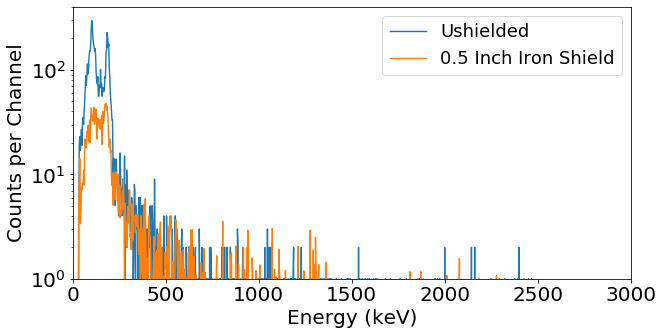

In [117]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,5))

linewidth = 1.4
energies = np.linspace(0,3000,1024)

spectra_cumsum_iron_recal = [rebin_spectrum(spectrum, a=0, b=1.15, c=0) for spectrum in spectra_cumsum_iron]

plt.semilogy(energies, spectra_cumsum_bare[0], label= 'Ushielded', linewidth=linewidth)
plt.semilogy(energies, spectra_cumsum_iron_recal[0], label= '0.5 Inch Iron Shield', linewidth=linewidth)
plt.legend(prop={'size': 18})

plt.xlim([0,3000])
plt.ylim([1e0,4e2])


plt.xlabel('Energy (keV)')
plt.ylabel('Counts per Channel')

In [50]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,5))

linewidth = 1.4
energies = np.linspace(0,3000,1024)
plt.semilogy(energies, spectra_cumsum_740V[3], label= 'Unshielded High Enriched Uranium', linewidth=linewidth)
plt.semilogy(energies, spectra_cumsum_740V_shielded[3], label = 'Shielded High Enriched Uranium', linewidth=linewidth)
plt.legend(prop={'size': 18})

plt.xlim([0,3000])
# plt.ylim([1,4e3])

plt.xlabel('Energy (keV)')
plt.ylabel('Counts per Channel')

NameError: name 'spectra_cumsum_740V' is not defined

<Figure size 720x360 with 0 Axes>

cnn-full predicts: 152EU
dnn-full predicts: 51CR
dae-full predicts: 99MO


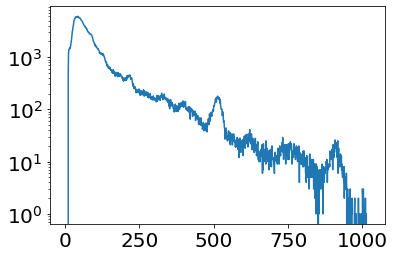

In [51]:
spectrum = read_spectrum('../../uranium-enrichment/rocky_flats_spectra/background_end_of_day.Spe')
for model_id in ['cnn-full', 'dnn-full', 'dae-full']:
    bagged_output, all_outputs = models_bagged(all_models_dataaug, model_id, [spectrum])
    print(model_id+' predicts: '+str(mlb.classes_[bagged_output[0]]))
plt.semilogy(spectrum)

cnn-full predicts: 235U
dnn-full predicts: 235U
dae-full predicts: 235U
cae-full predicts: 235U


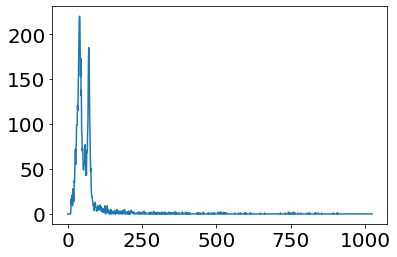

In [73]:
spectrum = []


# spectrum = read_spectrum('../../uranium-enrichment/rocky_flats_spectra/RFshells-750V/5s_TEST_number_000.Spe')
spectrum = read_spectrum('../../uranium-enrichment/rocky_flats_spectra/RFshells-750V/10s_TEST_number_000.Spe')
for model_id in ['cnn-full', 'dnn-full', 'dae-full', 'cae-full']:
    bagged_output, all_outputs = models_bagged(all_models_dataaug, model_id, [spectrum])
    print(model_id+' predicts: '+str(mlb.classes_[bagged_output[0]]))

plt.plot(spectrum)

### Compare integration time and calibration changes in real spectra

## Ba133

cnn-full:
79.7 133BA
11.1 51CR
8.6 237NP
0.2 233U
0.2 67GA


100.0 133BA
0.0 51CR
0.0 233U
0.0 237NP
0.0 131I


100.0 133BA
0.0 51CR
0.0 131I
0.0 233U
0.0 237NP


100.0 133BA
0.0 233U
0.0 51CR
0.0 131I
0.0 237NP


dnn-full:
52.3 51CR
34.3 237NP
3.0 131I
2.7 133BA
2.4 67GA


68.3 51CR
31.5 237NP
0.1 67GA
0.1 133BA
0.0 131I


61.0 51CR
38.9 237NP
0.0 67GA
0.0 133BA
0.0 233U


59.2 51CR
40.8 237NP
0.0 67GA
0.0 233U
0.0 133BA


dae-full:
42.8 51CR
21.1 237NP
13.6 133BA
7.4 131I
7.3 103PD


55.5 51CR
14.8 237NP
10.4 133BA
6.0 131I
5.3 103PD


50.5 51CR
16.1 237NP
12.1 133BA
6.0 131I
5.8 103PD


50.1 51CR
16.6 237NP
12.1 133BA
6.0 67GA
5.7 131I


cae-full:
41.9 133BA
24.5 239PU
3.2 237NP
1.2 75SE
1.2 233U


67.2 133BA
1.4 239PU
1.3 237NP
1.2 233U
1.1 67GA


67.1 133BA
1.6 239PU
1.2 233U
1.2 237NP
1.1 67GA


67.1 133BA
1.5 239PU
1.3 233U
1.2 237NP
1.2 67GA




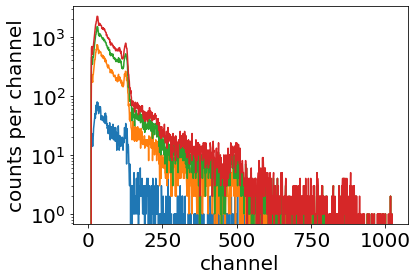

In [31]:
spectra = []

# for path in glob('../training_testing_data/06-21-19/ba133/detector131_745v_10s_ba133_none_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/ba133/detector131_745v_10s_ba133_al30_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/ba133/detector131_745v_10s_ba133_al50_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/ba133/detector131_745v_10s_ba133_al60_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/ba133/detector131_745v_10s_ba133_fe60_10sbr_*.Spe'):

# for path in glob('../training_testing_data/06-21-19/ba133/detector131_745v_10s_ba133_al30_10sbr_18-2cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/ba133/detector131_745v_10s_ba133_al30_10sbr_22cm_*.Spe'):
for path in glob('../training_testing_data/06-21-19/ba133/detector131_745v_10s_ba133_al60_10sbr_14-8cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/ba133/detector131_745v_10s_ba133_fe60_10sbr_17cm_*.Spe'):
    spectra.append(read_spectrum(path))
    
spectra_cumsum = np.cumsum(spectra, axis=0)

for i in [0,9,19,29]:
    plt.semilogy(spectra_cumsum[i])
    plt.xlabel('channel')
    plt.ylabel('counts per channel')

for model_id in ['cnn-full', 'dnn-full', 'dae-full', 'cae-full']:
# for model_id in ['cnn-easy', 'dnn-easy', 'dae-easy', 'cae-easy']:
#     for i in [0,9,19,29,39]:
    print(model_id + ':')
    for i in [0,9,19,29]:
        # bagged_output, all_outputs = models_bagged(all_models_dataaug, model_id, [spectra_cumsum[i]])
        predictions_from_bagged_model(all_models,
                                      model_id,
                                      [spectra_cumsum[i]],
                                      mlb.classes_,)


## Eu152

cnn-full:
43.0 152EU
35.3 103PD
18.8 67GA
1.8 131I
0.6 133BA


95.4 152EU
3.5 103PD
0.7 67GA
0.3 131I
0.0 75SE


93.3 152EU
5.0 103PD
1.1 67GA
0.5 131I
0.0 237NP


92.3 152EU
5.3 103PD
1.3 131I
1.0 67GA
0.0 51CR


dnn-full:
22.1 152EU
14.4 60CO
11.9 238U
8.3 background
7.1 99MO


44.5 152EU
28.5 60CO
18.2 238U
4.4 99MO
1.2 131I


48.6 152EU
24.8 238U
22.7 60CO
2.0 99MO
0.8 201TL


50.1 152EU
27.6 238U
20.5 60CO
0.9 99MO
0.5 201TL


dae-full:
14.0 241AM
11.2 133XE
10.6 204TL
10.4 238U
10.2 201TL


13.0 238U
12.8 241AM
11.0 201TL
9.9 133XE
9.1 204TL


12.7 241AM
12.5 238U
12.2 201TL
10.0 133XE
9.0 204TL


12.7 241AM
12.5 238U
12.2 201TL
10.1 133XE
9.1 204TL


cae-full:
86.5 152EU
6.8 133BA
3.0 103PD
2.3 239PU
0.8 233U


74.0 152EU
19.1 239PU
5.0 233U
0.8 67GA
0.7 133BA


60.1 152EU
33.3 239PU
5.3 233U
0.8 67GA
0.2 103PD


56.6 152EU
36.3 239PU
5.7 233U
0.9 67GA
0.2 133BA




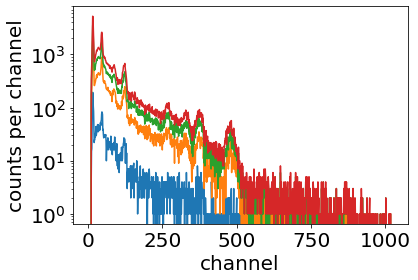

In [38]:
spectra = []

for path in glob('../training_testing_data/06-20-19/eu152/detector131_770v_10s_eu152_none_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/eu152/detector131_770v_10s_eu152_al20_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/eu152/detector131_770v_10s_eu152_al40_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/eu152/detector131_770v_10s_eu152_al60_10sbr_*.Spe'):

# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_al20_10sbr_47-8cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_al40_10sbr_44-6cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_al60_10sbr_34-3cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_fe1_10sbr_34-8cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_fe2_10sbr_30-1cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_fe3_10sbr_26-4cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_pb1_10sbr_30-5cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_pb2_10sbr_26-5cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_pb3_10sbr_25-0cm_*.Spe'):
    spectra.append(read_spectrum(path))
    
spectra_cumsum = np.cumsum(spectra, axis=0)

for i in [0,9,19,29]:
    plt.semilogy(spectra_cumsum[i])
    plt.xlabel('channel')
    plt.ylabel('counts per channel')
    
    
for model_id in ['cnn-full', 'dnn-full', 'dae-full', 'cae-full']:
# for model_id in ['cnn-easy', 'dnn-easy', 'dae-easy', 'cae-easy']:
#     for i in [0,9,19,29,39]:
    print(model_id + ':')
    for i in [0,9,19,29]:
        # bagged_output, all_outputs = models_bagged(all_models_dataaug, model_id, [spectra_cumsum[i]])
        predictions_from_bagged_model(all_models_dataaug,
                                      model_id,
                                      [spectra_cumsum[i]],
                                      mlb.classes_,)

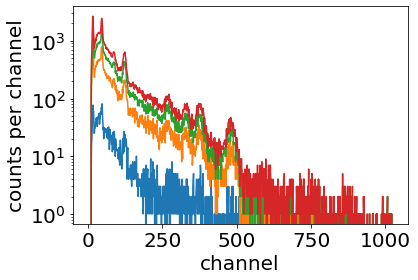

In [41]:
spectra = []

# for path in glob('../training_testing_data/06-20-19/eu152/detector131_770v_10s_eu152_none_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/eu152/detector131_770v_10s_eu152_al20_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/eu152/detector131_770v_10s_eu152_al40_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/eu152/detector131_770v_10s_eu152_al60_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/eu152/detector131_770v_10s_eu152_fe50_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/eu152/detector131_770v_10s_eu152_pb60_10sbr_*.Spe'):

for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_al20_10sbr_47-8cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_al40_10sbr_44-6cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_al60_10sbr_34-3cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_fe1_10sbr_34-8cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_fe2_10sbr_30-1cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_fe3_10sbr_26-4cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_pb1_10sbr_30-5cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_pb2_10sbr_26-5cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/eu152/detector131_745v_10s_eu152_pb3_10sbr_25-0cm_*.Spe'):
    spectra.append(read_spectrum(path))
    
spectra_cumsum = np.cumsum(spectra, axis=0)

for i in [0,9,19,29]:
    plt.semilogy(spectra_cumsum[i])
    plt.xlabel('channel')
    plt.ylabel('counts per channel')
    


## Co60

cnn-full:
62.5 238U
37.1 60CO
0.3 background
0.1 204TL
0.0 152EU


59.3 60CO
40.7 238U
0.0 background
0.0 57CO
0.0 152EU


61.7 60CO
38.3 238U
0.0 57CO
0.0 background
0.0 152EU


59.0 60CO
41.0 238U
0.0 background
0.0 57CO
0.0 152EU


dnn-full:
46.4 60CO
17.9 238U
12.4 152EU
5.1 background
4.8 137CS


75.2 60CO
22.6 238U
2.1 152EU
0.1 99MO
0.0 137CS


70.2 60CO
29.0 238U
0.8 152EU
0.0 99MO
0.0 137CS


65.7 60CO
33.8 238U
0.5 152EU
0.0 99MO
0.0 137CS


dae-full:
61.2 60CO
15.9 238U
13.3 152EU
4.1 99MO
2.7 background


69.1 60CO
15.9 238U
9.4 152EU
2.2 99MO
1.8 background


70.8 60CO
14.3 238U
9.2 152EU
2.5 99MO
1.8 background


70.8 60CO
14.4 238U
9.2 152EU
2.4 99MO
1.8 background


cae-full:
79.3 60CO
20.7 238U
0.0 152EU
0.0 background
0.0 137CS


94.9 60CO
5.0 238U
0.1 152EU
0.0 103PD
0.0 137CS


79.0 60CO
20.9 238U
0.2 152EU
0.0 103PD
0.0 137CS


72.9 60CO
26.9 238U
0.2 152EU
0.0 103PD
0.0 137CS




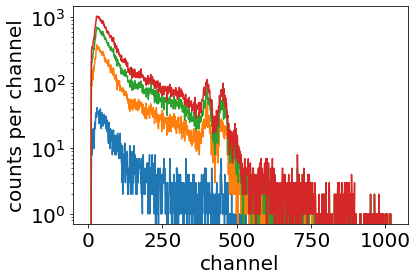

In [45]:
spectra = []

# for path in glob('../training_testing_data/06-20-19/co60/detector131_770v_10s_co60_none_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/co60/detector131_770v_10s_co60_al40_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/co60/detector131_770v_10s_co60_al20_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/co60/detector131_770v_10s_co60_fe10_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/co60/detector131_770v_10s_co60_fe15_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/co60/detector131_770v_10s_co60_fe40_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/co60/detector131_770v_10s_co60_fe60_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/co60/detector131_770v_10s_co60_pb15_10sbr_*.Spe'):
# for path in glob('../training_testing_data/06-20-19/co60/detector131_770v_10s_co60_pb40_10sbr_*.Spe'):
for path in glob('../training_testing_data/06-20-19/co60/detector131_770v_10s_co60_pb60_10sbr_*.Spe'):

# for path in glob('../training_testing_data/06-21-19/co60/detector131_745v_10s_co60_al20_10sbr_13-6cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/co60/detector131_745v_10s_co60_fe20_10sbr_14-7cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/co60/detector131_745v_10s_co60_fe40_10sbr_12-5cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/co60/detector131_745v_10s_co60_fe60_10sbr_10-3cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/co60/detector131_745v_10s_co60_pb20_10sbr_15cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/co60/detector131_745v_10s_co60_pb40_10sbr_12-3cm_*.Spe'):
# for path in glob('../training_testing_data/06-21-19/co60/detector131_745v_10s_co60_pb60_10sbr_9-9cm_*.Spe'):
    spectra.append(read_spectrum(path))
    
spectra_cumsum = np.cumsum(spectra, axis=0)

for i in [0,9,19,29]:
    plt.semilogy(spectra_cumsum[i])
    plt.xlabel('channel')
    plt.ylabel('counts per channel')
    
for model_id in ['cnn-full', 'dnn-full', 'dae-full', 'cae-full']:
# for model_id in ['cnn-easy', 'dnn-easy', 'dae-easy', 'cae-easy']:
#     for i in [0,9,19,29,39]:
    print(model_id + ':')
    for i in [0,9,19,29]:
        # bagged_output, all_outputs = models_bagged(all_models_dataaug, model_id, [spectra_cumsum[i]])
        predictions_from_bagged_model(all_models_dataaug,
                                      model_id,
                                      [spectra_cumsum[i]],
                                      mlb.classes_,)

## Gain change that shit

In [541]:
from scipy.interpolate import griddata

def rebin_spectrum(spectrum_template, a=0, b=1, c=0):
    '''
    Rebins spectrum based on quadratic rebinning. Returns a 1024 channel
    spectrum.

    inputs:
        spectrum_template : vector (1x1194)
            The spectrums template
        a : float
            Constant rebinning term
        b : float
            Linear rebinning term
        c : float
            Quadratic rebinning term
    returns:
        rebinned_spectrum_template : vector (1x1194)
            The rebinned spectrum template
    '''

    new_bin_positions = a + b*np.arange(1024) + c*np.arange(1024)**2

    spectrum_template = griddata(np.arange(1024),
                                 spectrum_template,
                                 new_bin_positions,
                                 method='cubic',
                                 fill_value=0.0)
    spectrum_template[spectrum_template < 0] = 0
    return spectrum_template[:1024]

In [50]:
spectra_cumsum = [rebin_spectrum(spectrum, a=0, b=0.9, c=0) for spectrum in spectra_cumsum]



IndexError: list index out of range

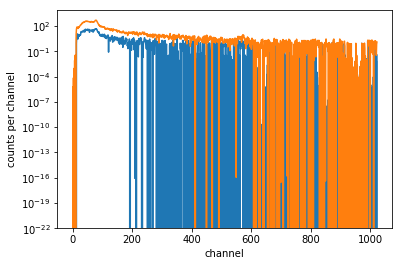

In [51]:
for i in [0,9,19,29]:
    plt.semilogy(spectra_cumsum[i])
    plt.xlabel('channel')
    plt.ylabel('counts per channel')

# Full Training set 
#### Augmented

In [47]:
for model_id in ['cnn-full', 'dnn-full', 'dae-full']:
    for i in [0,9,19,29]:
        bagged_output, all_outputs = models_bagged(all_models_dataaug, model_id, [spectra_cumsum[i]])
        print(model_id+' predicts: '+str(mlb.classes_[bagged_output[0]]))
#         _ = [print(mlb.classes_[k][0]) for k in all_outputs]
    print('\n')

cnn-full predicts: 238U
cnn-full predicts: 238U
cnn-full predicts: 238U
cnn-full predicts: 238U


dnn-full predicts: 60CO
dnn-full predicts: 60CO
dnn-full predicts: 60CO
dnn-full predicts: 238U


dae-full predicts: 60CO
dae-full predicts: 60CO
dae-full predicts: 60CO
dae-full predicts: 60CO




#### Fixed

In [172]:
for model_id in ['cnn-full', 'dnn-full', 'dae-full']:
    for i in [0,9,19,29]:
        bagged_output, all_outputs = models_bagged(all_models, model_id, [spectra_cumsum[i]])
        print(model_id+' predicts: '+str(mlb.classes_[bagged_output[0]]))
#         _ = [print(mlb.classes_[k][0]) for k in all_outputs]
    print('\n')

cnn-full predicts: 60CO
cnn-full predicts: 60CO
cnn-full predicts: 60CO
cnn-full predicts: 60CO


dnn-full predicts: 60CO
dnn-full predicts: 60CO
dnn-full predicts: 60CO
dnn-full predicts: 60CO


dae-full predicts: 152EU
dae-full predicts: 60CO
dae-full predicts: 60CO
dae-full predicts: 60CO




### Easy Training set
#### Augmented

In [173]:
for model_id in ['cnn-easy', 'dnn-easy', 'dae-easy']:
    for i in [0,9,19,29]:
        bagged_output, all_outputs = models_bagged(all_models, model_id, [spectra_cumsum[i]])
        print(model_id+' predicts '+str(mlb.classes_[bagged_output[0]]))
#         _ = [print(mlb.classes_[k][0]) for k in all_outputs]
    print('\n')

cnn-easy predicts 152EU
cnn-easy predicts 60CO
cnn-easy predicts 60CO
cnn-easy predicts 60CO


dnn-easy predicts 60CO
dnn-easy predicts 60CO
dnn-easy predicts 60CO
dnn-easy predicts 60CO


dae-easy predicts 51CR
dae-easy predicts 152EU
dae-easy predicts 152EU
dae-easy predicts 152EU




#### Fixed

In [174]:
for model_id in ['cnn-easy', 'dnn-easy', 'dae-easy']:
    for i in [0,9,19,29]:
        bagged_output, all_outputs = models_bagged(all_models, model_id, [spectra_cumsum[i]])
        print(model_id+' predicts: '+str(mlb.classes_[bagged_output[0]]))
#         _ = [print(mlb.classes_[k][0]) for k in all_outputs]
    print('\n')

cnn-easy predicts: 152EU
cnn-easy predicts: 60CO
cnn-easy predicts: 60CO
cnn-easy predicts: 60CO


dnn-easy predicts: 60CO
dnn-easy predicts: 60CO
dnn-easy predicts: 60CO
dnn-easy predicts: 60CO


dae-easy predicts: 51CR
dae-easy predicts: 152EU
dae-easy predicts: 152EU
dae-easy predicts: 152EU


